In [5]:
import os, shutil
import cv2
import zipfile

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
def zipdir(src_path: str, zip_file: zipfile.ZipFile):
    ''' add dirctory with relative path to the zip archive

    Args:
      src_path: path to the directory
      zip_file: zip archive
    '''
    for root, dirs, files in os.walk(src_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, src_path)
            zip_file.write(file_path, arcname)

def archive_directory(src_dir: str, dst_file: str):
    ''' archive directory

    Args:
      src_dir: path to the directory
      dst_file: name of the archive
    '''
    with zipfile.ZipFile(dst_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir(src_dir, zipf)

In [7]:
USE_COLAB = True


MODEL_NAME = 'HandMade'
SEED = 42
image_size = (224, 224)
batch_size = 32

In [8]:
dataset_dir = os.path.join('../', 'data', 'SmallPreprocessed')

if USE_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    filename = 'smallpreprocessed.zip'

    dest_path = f'{filename}_extracted'
    shutil.rmtree(dest_path, ignore_errors=True)

    with zipfile.ZipFile( os.path.join('/content/drive/MyDrive', filename), 'r') as zip_ref:
        zip_ref.extractall(dest_path)


    dataset_dir = os.path.join('/content/', dest_path, 'data', 'SmallPreprocessed')

Mounted at /content/drive


In [9]:
datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [10]:
class_num = list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [11]:
model = keras.models.Sequential()

model.add(Conv2D(32, (4, 4), activation="relu", input_shape=(image_size[0], image_size[1], 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(128, (4, 4), activation="relu"))
model.add(Flatten())

model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5, seed=SEED))

model.add(Dense(len(class_num), activation="softmax"))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 221, 221, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 70, 70, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 3, 3, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,020,260 (3.89 MB)

 Trainable params: 1,020,260 (3.89 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
checkpoint_cb = ModelCheckpoint(
    f"model_{MODEL_NAME}_checkpoint.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [13]:
EPOCHS = 20

In [14]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 44s 99ms/step - accuracy: 0.3774 - loss: 1.2388 - val_accuracy: 0.6150 - val_loss: 0.7460
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 31s 82ms/step - accuracy: 0.6676 - loss: 0.7053 - val_accuracy: 0.7230 - val_loss: 0.5883
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 88ms/step - accuracy: 0.7739 - loss: 0.5162 - val_accuracy: 0.8080 - val_loss: 0.4365
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8351 - loss: 0.3862 - val_accuracy: 0.8315 - val_loss: 0.4119
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 43s 84ms/step - accuracy: 0.8814 - loss: 0.2828 - val_accuracy: 0.8645 - val_loss: 0.3712
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 33s 89ms/step - accuracy: 0.9108 - loss: 0.2288 - val_accuracy: 0.8905 - val_loss: 0.2883
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 80ms/step - accuracy: 0.9292 - loss: 0.1842 - val_accuracy: 0.8980 - val_loss: 0.2899
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 30s 81ms/step - accuracy: 0.9458 - loss: 0.1366 - 

In [15]:
if USE_COLAB:
    model_dir = os.path.join('/content/', 'models')
    zip_name = os.path.join('/content/', f'{MODEL_NAME}_model.zip')
    gdrive_file = os.path.join('/content/drive/MyDrive/', f'{MODEL_NAME}_model.zip')

    os.makedirs(model_dir, exist_ok=True)

    model.save(os.path.join(model_dir, f'{MODEL_NAME}_model.keras'))
    model.export(os.path.join(model_dir, MODEL_NAME))
    archive_directory(model_dir, zip_name)

    if os.path.exists(zip_name):
        os.remove(zip_name)

    archive_directory(model_dir, zip_name)

    shutil.copyfile(zip_name, gdrive_file)

    shutil.rmtree(model_dir, ignore_errors=True)
    os.remove(zip_name)

    print(f"model data was stored on google drive as {gdrive_file}")
else:
    model.save(f'../models/{MODEL_NAME}_model.keras')
    model.export(f'../models/{MODEL_NAME}_model')


Saved artifact at '/content/models/HandMade'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  135248997200912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248854495504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947240336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947240720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947242832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947243600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947243216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947242640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947244176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248947244944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135248

In [16]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9313 - loss: 0.2342
Val Loss = 0.285214900970459
Val Accuracy = 0.9054999947547913


In [17]:
hist_=pd.DataFrame(hist.history)

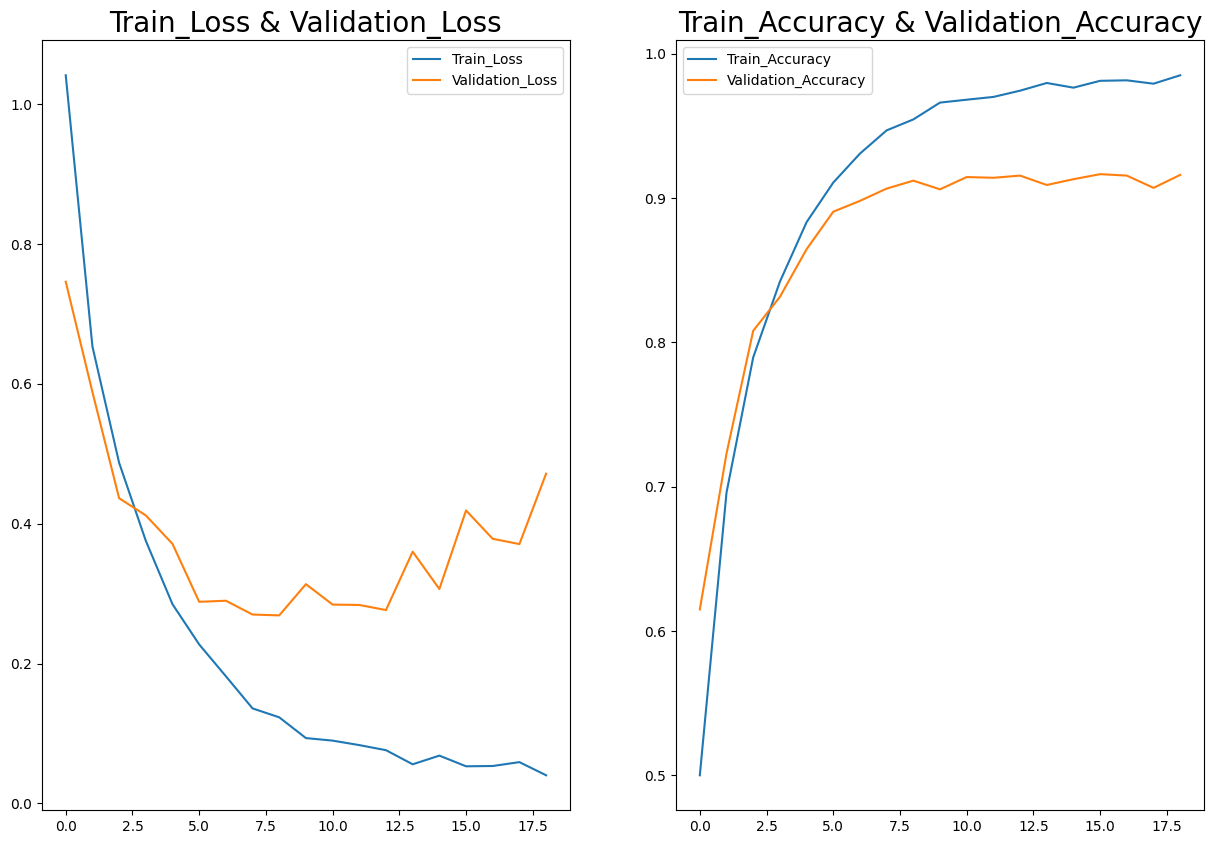

In [18]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [19]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step


array([[459,   9,  10,  22],
       [  1, 497,   0,   2],
       [ 10,   2, 436,  52],
       [ 32,   3,  46, 419]])

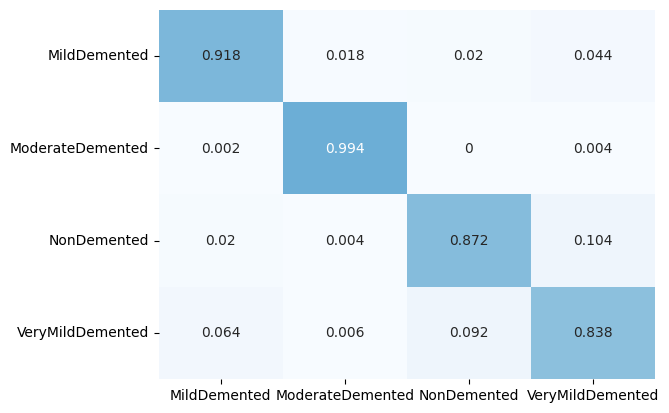

In [20]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [22]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
                   precision    recall  f1-score   support

    MildDemented       0.91      0.92      0.92       500
ModerateDemented       0.97      0.99      0.98       500
     NonDemented       0.89      0.87      0.88       500
VeryMildDemented       0.85      0.84      0.84       500

        accuracy                           0.91      2000
       macro avg       0.90      0.91      0.91      2000
    weighted avg       0.90      0.91      0.91      2000

